# Preprocessing

In this notebook we will pre-process the data. The main steps here are:

- Cell and gene filtering
- Cell-wise count normalization
- Variance correction and identification of highly variable genes (HVGs)
- Dimensionality reduction using PCA

We will use the [Dataset](../../../api.rst#dataset) class for these purposes.

Start with changing the working directory to wherever the data is located.

In [1]:
import nabo

The `mtx_to_h5` function can easily convert [MTX format](https://math.nist.gov/MatrixMarket/formats.html) data (an output of 10x's [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) pipeline) into the [HDF5](https://www.hdfgroup.org/) format. The commands below read and convert the data for two sample visualizations, **WT** and **MLL-ENL**, into HDF5 format. Each command takes three parameters:

- path to the directory containing three files ('matrix.mtx', 'genes.tsv' and 'barcodes.tsv')
- name of the output file
- `batch_size`. Larger values of `batch_size` will allow the data to be written to HDF5 format faster, but will also lead to larger memory consumption.

Once the data is saved into HDF5 format, you don't have to run this command again, even if you want to re-run the rest of the notebook.

In [2]:
nabo.mtx_to_h5('../raw_data/WT', '../analysis_data/WT.h5', batch_size=1000)
nabo.mtx_to_h5('../raw_data/MLL_ENL', '../analysis_data/MLL_ENL.h5', batch_size=1000)

Saving cell-wise data          : 100%| 00:00
Saving gene-wise data          : 100%| 00:00
Saving cell-wise data          : 100%| 00:00
Saving gene-wise data          : 100%| 00:00


In the cell below, the **WT** sample data is visualized using the [Dataset](../../../api.rst#dataset) class. The sample data is already saved in the HDF5 format. Basic statistics are visualized using the [plot_raw](../../../api.rst#nabo.Dataset.plot_raw) method of the returned instance of Dataset.

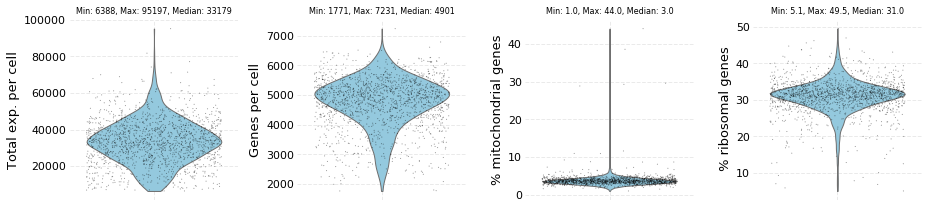

The dataset contains: 1578 cells and 27998 genes


In [3]:
# use force_recalc=True to ensure that previously saved information is overwritten.
wt_data = nabo.Dataset('../analysis_data/WT.h5', force_recalc=True)
wt_data.plot_raw()

Next, poor quality cells and genes are removed by calling [filter_data](../../../api.rst#nabo.Dataset.filter_data) method with minimum and maximum threshold values for the following parameters:

- total expression values (can be total UMIs/counts per cell)
- number genes expressed per cell
- percentage of mitochondrial gene expression (ex. % UMI from mito genes) in each cell
- percentage of ribosomal gene expression (ex. % UMI from ribo genes) in each cell
- minimum number of cells where a gene should be expressed i.e. have non zero expression value.

The filtered data is visualized using [plot_filtered](../../../api.rst#nabo.Dataset.plot_filtered) method. The number of cells and genes filtered for each cutoff are also displayed.

UMI filtered  : Low: 0 High: 30
Gene filtered : Low: 4 High: 4
Mito filtered : Low: 0 High: 70
Ribo filtered : Low: 39 High: 35


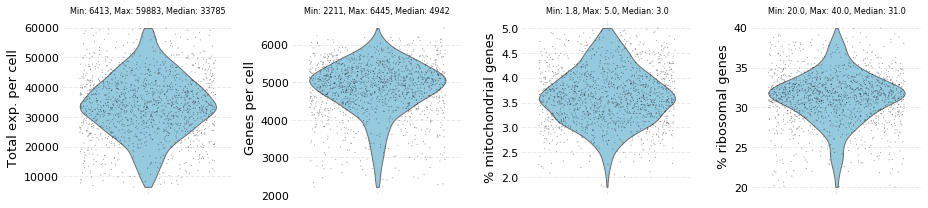

The dataset contains: 1414 cells and 12035 genes


In [4]:
wt_data.filter_data(min_exp=6000, max_exp=60000, min_ngenes=2000, max_ngenes=6500,
                    min_mito=0, max_mito=5, min_ribo=20, max_ribo=40)
wt_data.plot_filtered()

Other samples can be be loaded and filtered in a similar way. At this stage no distinction is made over which sample would be a reference and which would be a target sample.

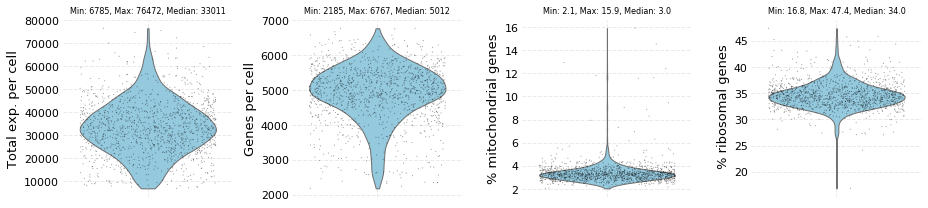

The dataset contains: 1284 cells and 27998 genes


In [5]:
me_data = nabo.Dataset('../analysis_data/MLL_ENL.h5', force_recalc=True)
me_data.plot_raw()

UMI filtered  : Low: 0 High: 25
Gene filtered : Low: 0 High: 8
Mito filtered : Low: 0 High: 30
Ribo filtered : Low: 11 High: 41


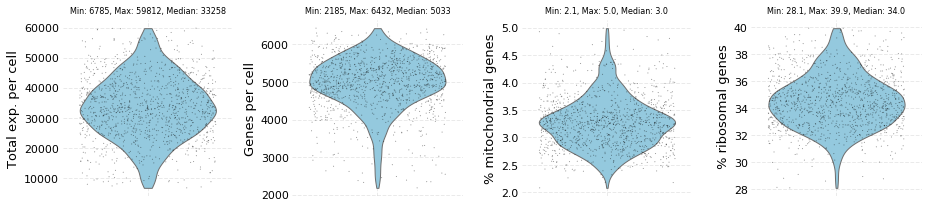

The dataset contains: 1182 cells and 12062 genes


In [6]:
me_data.filter_data(min_exp=6000, max_exp=60000, min_ngenes=2000, max_ngenes=6500,
                        min_mito=0, max_mito=5, min_ribo=28, max_ribo=40)
me_data.plot_filtered()

The next step is normalization, which accounts for sequencing depth of each cell such that cross cell comparisons can be made. Normalization is performed over a dataset using the [set_sf](../../../api.rst#nabo.Dataset.set_sf) method. During this step Nabo simply saves the size factors for each cell, and will later use these size factors for normalization. By default, the size factor for each cell is calculated by summing the expression values of genes in a cell. However, users can override this behaviour by providing their own size factors. By default, [set_sf](../../../api.rst#nabo.Dataset.set_sf) method will take only the filtered genes into account. This behaviour can be controlled by toggling the `use_filtered_genes` parameter to either `True` (default) or `False`. This step is recommended even if data is pre-normalized.

In [7]:
wt_data.set_sf()
me_data.set_sf()

Next, we correct variance to remove any mean-variance trend. This step is essential before the HVGs (highly variable genes) can be found. This step can be skipped if you already have a list of HVGs. Please refer to the documentation on [correct_var](../../../api.rst#nabo.Dataset.correct_var) to learn more about this step.

In [8]:
wt_data.correct_var(n_bins=100, lowess_frac=0.5)

To identify HVGs, [find_hvgs](../../../api.rst#nabo.Dataset.find_hvgs) method is called with a cutoff for variance (`var_min_thresh`) and non-zero mean (`nzm_min_thresh`) in log scale. This method will also produce three subplots which are useful in order to to study variance correction and genes selected as HVGs. In all three plots the blue dots are the HVGs and grey dots are other genes.

- The third subplot shows the trend between log mean and log variance. The red dots (may look like a line because dots overlaps) show the Lowess fitted baseline.
- The middle subplot has corrected variance on the y axis and one may see that the mean-variance trend no longer exists or has diminished.
- The first plot on the left has log of corrected variance on the y axis and log non-zero mean on x axis; the vertical and horizontal lines represent the cutoffs used for marking HVGs.

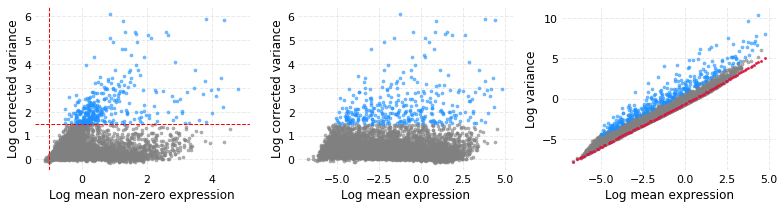

328 highly variable genes found


In [9]:
wt_data.find_hvgs(var_min_thresh=1.5, nzm_min_thresh=-1, use_corrected_var=True)

It is critical to observe here that variance correction and HVG identification was done only on one sample (`wt_data` in this case). This is because we aim to use cells from  this sample as [reference cells](../../../glossary.rst), while cells from the other sample will be regarded as [target cells](../../../glossary.rst) for downstream analysis.

So, **WT** are the *reference cells* and **MLL-ENL** are the *target cells*.

Next, we do PCA using the [fit_ipca](../../../api.rst#nabo.Dataset.fit_ipca) method.

In [10]:
wt_data.fit_ipca(wt_data.hvgList, n_comps=100)

Before we transform the values from reference and target into PCA space, it can be useful to visualize the variance explained by the PC components. The [plot_scree](../../../api.rst#nabo.Dataset.transform_pca) method generates two subplots. The topmost one is the usual scree plot, while the one at the bottom shows cumulative explained variance on the y-axis. [plot_scree](../../../api.rst#nabo.Dataset.transform_pca) takes three parameters:

- PCA object (`ipca` attribute of reference sample).
- Target variance: PC component where cumulative variance reached target variance is marked by a vertical line.
- Number of components to show.

Variance target closest at PC15


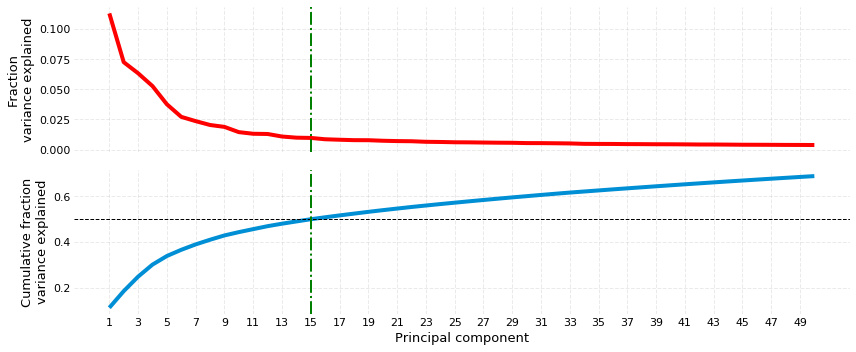

In [11]:
nabo.plot_scree(wt_data.ipca, 0.5, 50)

Now we transform reference and target cells into PCA space using the [transform_pca](../../../api.rst#nabo.Dataset.transform_pca) method. Before we transform them into PCA space, we save mean and variance of each of the genes used for fitting PCA (i. e. the HVGs) into a dataframe (called `scaling_params` below). These means and variances are calculated from the reference sample using the [get_scaling_params](../../../api.rst#nabo.Dataset.get_scaling_params) method, and is used to z-scale genes. It is important to note that the same scaling parameters obtained from the reference sample are also used for the target sample(s). Scaling is performed within the [transform_pca](../../../api.rst#nabo.Dataset.transform_pca) method.

In [12]:
scaling_params = wt_data.get_scaling_params(wt_data.ipca.genes)
wt_data.transform_pca('../analysis_data/hvg_pca_WT.h5', 'data', wt_data.ipca, scaling_params)
me_data.transform_pca('../analysis_data/hvg_pca_ME.h5', 'data', wt_data.ipca, scaling_params)

The last preprocessing step is to generate a control dataset. The implicit idea behind using HVGs is to segregate those reference cells that imply that genes with very low variability will have the least capability to differentiate the reference cells from one another. Using such genes as control for performing cross-sample cell mapping can prove to be a useful control, as we will see in later stages of analysis. The [get_lvgs](../../../api.rst#nabo.Dataset.get_lvgs) method allows for easy obtaining of low variance genes (LVGs). The genes with (log) non-zero mean expression below the value of parameter `nzm_cutoff` (or `log_nzm_cutoff`) are  not included in LVG list.

Next, we use these LVGs to fit PCA.

In [13]:
lvgs = wt_data.get_lvgs(log_nzm_cutoff=-1, use_corrected_var=True)
wt_data.fit_ipca(lvgs)

As before, we transform the reference and target cells using LVG-fitted PCA and save them to a different file (one can save them to the same file as well using a different group name).

In [14]:
scaling_params = wt_data.get_scaling_params(wt_data.ipca.genes)
wt_data.transform_pca('../analysis_data/lvg_pca_WT.h5', 'data', wt_data.ipca, scaling_params)
me_data.transform_pca('../analysis_data/lvg_pca_ME.h5', 'data', wt_data.ipca, scaling_params)